<a href="https://colab.research.google.com/github/RautRitesh/EfficientNetB0-X-Ray-Classifier/blob/main/Pneumonia_or_not.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Welcome to my Notebook.In this notebook we will be trying to  Create an "Fine tuned versionüî•üî•" of "EfficientNetB0" using "Tensorflow Transfer Learningüìöüìö".


Dataset URL: https://www.kaggle.com/datasets/jamiedowat/chest-xray-images-guangzhou-women-and-childrens
License(s): unknown


In [3]:
import zipfile


Unzipping the datasets and extracting it. The data set is present in the kaggle . To access it follow the  link:"https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia"

In [4]:
zep_ref= zipfile.ZipFile("/content/chest-xray-images-guangzhou-women-and-childrens.zip")
zep_ref.extractall()
zep_ref.close()

All the required python library and tools are imported

In [5]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import pathlib

##Using pathlib to see the distibution of images.

In [9]:
for dirpath,dirnames,filenames in os.walk("/content/chest_xray/chest_xray_ternary"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 2 directories and 0 images in /content/chest_xray/chest_xray_ternary
There are 3 directories and 0 images in /content/chest_xray/chest_xray_ternary/test
There are 0 directories and 234 images in /content/chest_xray/chest_xray_ternary/test/NORMAL
There are 0 directories and 242 images in /content/chest_xray/chest_xray_ternary/test/BACTERIAL
There are 0 directories and 148 images in /content/chest_xray/chest_xray_ternary/test/VIRAL
There are 3 directories and 0 images in /content/chest_xray/chest_xray_ternary/train
There are 0 directories and 1349 images in /content/chest_xray/chest_xray_ternary/train/NORMAL
There are 0 directories and 2538 images in /content/chest_xray/chest_xray_ternary/train/BACTERIAL
There are 0 directories and 1345 images in /content/chest_xray/chest_xray_ternary/train/VIRAL


So sadüò•üò• the distribution of data for "Pneumonia" and "Normal" are not balanced this means there is maximum probability of our final model to be biasedüò≠üò≠

In [12]:
train_dir = pathlib.Path("/content/chest_xray/chest_xray_ternary/train")
class_names=np.array(sorted([item.name for item in train_dir.glob("*")]))

In [13]:
print(class_names)

['BACTERIAL' 'NORMAL' 'VIRAL']


In [14]:
print(class_names)

['BACTERIAL' 'NORMAL' 'VIRAL']


Helper function to see how is the images , shape of images . This is done in order to be one with the dataüíñüíñüíñüíñ

In [21]:
def show_images(target_class,target_dir):
  target_folder = target_dir + target_class;
  target_image=random.sample(os.listdir(target_folder),1)
  image = mpimg.imread(target_folder + "/" + target_image[0])
  plt.imshow(image/255)
  plt.title(target_class)
  print(f'{image.shape}')
  plt.show()

(1024, 1472)


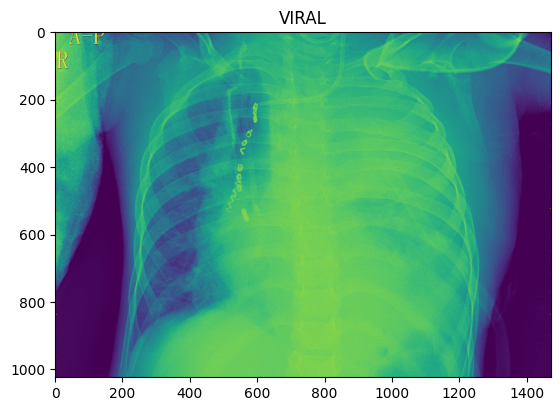

In [22]:
show_images(target_class=random.choice(class_names),target_dir="/content/chest_xray/chest_xray_ternary/train/")

In [23]:
train_dir="/content/chest_xray/chest_xray_ternary/train"
test_dir="/content/chest_xray/chest_xray_ternary/test"

Creating train_data , test_data by default tensorflow has batch of 32

In [24]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
  directory=train_dir,
  label_mode="categorical",
  image_size=(224,224)
)
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_dir,
    label_mode="categorical",
    image_size=(224,224)
)




Found 5232 files belonging to 3 classes.
Found 624 files belonging to 3 classes.


##Creating Data Augmentation layer. So that different images will be passed with some effects.

In [25]:
# Get the shape of images from train_data
for images, labels in train_data.take(1):  # Take the first batch
    print(f"Batch shape: {images.shape}")
    print(f"Single image shape: {images[0].shape}")
    print(f"Data type: {images.dtype}")

Batch shape: (32, 224, 224, 3)
Single image shape: (224, 224, 3)
Data type: <dtype: 'float32'>


In [26]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomRotation(0.2),

])

##Loading our Pretrained model to see the power of transfer learning. for more details go to"https://www.tensorflow.org/api_docs/python/tf/keras/applications"

###Include_top = false as we donot want to use the entire pretrained model only its body are used

In [30]:
base_model= tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

## Creating our neural network, Input layer recieved input and passes to our base_model whose result goes through Global Average Pooling2D and then some Dropout is done so that our model wont get overfitted.As our final predictions are only 2. i.e either noraml or pneumonia so we use "sigmoid" else "softmax" has to be  used

In [41]:
input = tf.keras.layers.Input(shape=(224,224,3))
x= data_augmentation(input)
x= base_model(x,training=False)
x=tf.keras.layers.GlobalAveragePooling2D()(x)
x= tf.keras.layers.Dropout(0.25)(x)
output= tf.keras.layers.Dense(3,activation="softmax")(x)
model = tf.keras.Model(input,output)

In [46]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'],
              optimizer= tf.keras.optimizers.Adam(learning_rate=1e-4))

In [47]:
checkpoint_path="best_model.weights.h5"

In [48]:
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_best_only =True ,
    save_weights_only = True,
    monitor='val_accuracy'
)

In [49]:
history_1 = model.fit(train_data,epochs=10,validation_data=test_data,callbacks=[checkpoint_callback])

Epoch 1/10
164/164 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 56s 252ms/step - accuracy: 0.3875 - loss: 1.1387 - val_accuracy: 0.5353 - val_loss: 0.9903
Epoch 2/10
164/164 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 74s 226ms/step - accuracy: 0.5697 - loss: 0.9239 - val_accuracy: 0.5849 - val_loss: 0.8869
Epoch 3/10
164/164 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 37s 227ms/step - accuracy: 0.6186 - loss: 0.8371 - val_accuracy: 0.6587 - val_loss: 0.8210
Epoch 4/10
164/164 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 39s 239ms/step - accuracy: 0.6553 - loss: 0.7881 - val_accuracy: 0.6715 - val_loss: 0.7919
Epoch 5/10
164/164 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 37s 226ms/step - accuracy: 0.6746 - loss: 0.7462 - val_accuracy: 0.7131 - val_loss: 0.7535
Epoch 6/10
164/164 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 37s 225ms/step - accuracy: 0.6907 - loss: 0.7237 - val_accuracy: 

Accuracy of our model in training data set is 88% where as on  testing one if only 77%

#creating a helper function so that we can predict a random images and see the outcome along with displaying the actual image

In [50]:
def pred_and_show(filename, model=model, image_size=224, class_name=class_names):
    # Read and decode image
    image = tf.io.read_file(filename)
    image = tf.io.decode_image(image)
    print(image.shape)

    # Convert grayscale to RGB if needed
    if image.shape[-1] == 1:
        image = tf.image.grayscale_to_rgb(image)

    # Resize image for model input
    image = tf.image.resize(image, size=[image_size, image_size])

    # Make prediction
    pred_probs = model.predict(tf.expand_dims(image, axis=0))
    pred_class = class_name[int(tf.argmax(pred_probs, axis=1))]

    # Display image with prediction
    plt.imshow(image/255)
    plt.title(pred_class)
    print(f"{pred_probs}")
    plt.axis(False)

(2022, 2000, 3)
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 2s/step
[[0.26894182 0.68795884 0.04309941]]


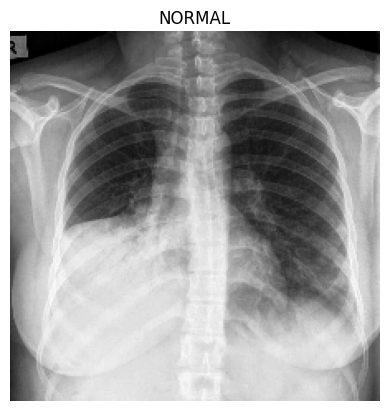

In [63]:
pred_and_show(filename="/content/pneumonia.jpg")

(1200, 1200, 1)
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 60ms/step
[[0.18996823 0.33164525 0.47838646]]


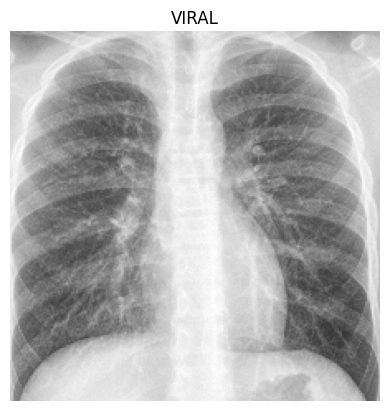

In [64]:
pred_and_show(filename="/content/p_2.jpeg")

(220, 235, 3)
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 51ms/step
[[0.4936684  0.3064051  0.19992656]]


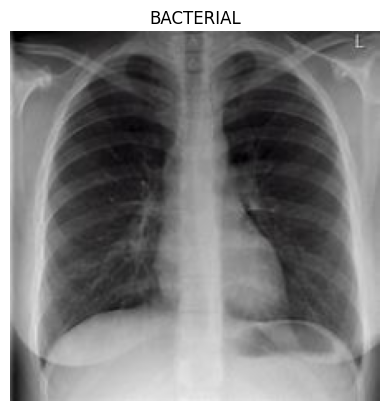

In [65]:
pred_and_show(filename="/content/normal.jpeg")

(778, 800, 3)
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 53ms/step
[[0.04393959 0.9048642  0.05119625]]


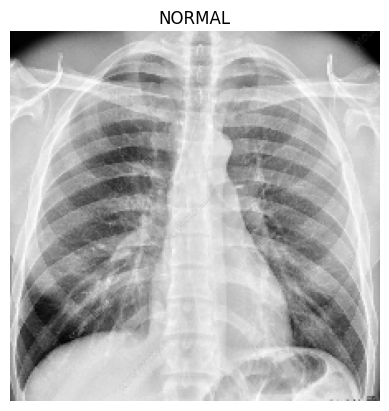

In [66]:
pred_and_show(filename="/content/normal.jpg")

In [56]:
model.layers

[<InputLayer name=input_layer_7, built=True>,
 <Sequential name=sequential, built=True>,
 <Functional name=efficientnetb0, built=True>,
 <GlobalAveragePooling2D name=global_average_pooling2d_4, built=True>,
 <Dropout name=dropout_4, built=True>,
 <Dense name=dense_4, built=True>]

##Now fine tuning our modelüê¶‚Äçüî•üê¶‚Äçüî•üê¶‚Äçüî•üê¶‚Äçüî•

In [57]:
base_model.trainable=True

In [58]:
for i,layer in enumerate(base_model.layers):
  print(i,layer.name,layer.trainable)

0 input_layer_4 True
1 rescaling_2 True
2 normalization_1 True
3 rescaling_3 True
4 stem_conv_pad True
5 stem_conv True
6 stem_bn True
7 stem_activation True
8 block1a_dwconv True
9 block1a_bn True
10 block1a_activation True
11 block1a_se_squeeze True
12 block1a_se_reshape True
13 block1a_se_reduce True
14 block1a_se_expand True
15 block1a_se_excite True
16 block1a_project_conv True
17 block1a_project_bn True
18 block2a_expand_conv True
19 block2a_expand_bn True
20 block2a_expand_activation True
21 block2a_dwconv_pad True
22 block2a_dwconv True
23 block2a_bn True
24 block2a_activation True
25 block2a_se_squeeze True
26 block2a_se_reshape True
27 block2a_se_reduce True
28 block2a_se_expand True
29 block2a_se_excite True
30 block2a_project_conv True
31 block2a_project_bn True
32 block2b_expand_conv True
33 block2b_expand_bn True
34 block2b_expand_activation True
35 block2b_dwconv True
36 block2b_bn True
37 block2b_activation True
38 block2b_se_squeeze True
39 block2b_se_reshape True
40 b

In [59]:
for layer in base_model.layers[:-10]:
  layer.trainable=False

In [60]:
for i,layer in enumerate(base_model.layers):
  print(i,layer.name,layer.trainable)

0 input_layer_4 False
1 rescaling_2 False
2 normalization_1 False
3 rescaling_3 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [61]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=["accuracy"])

In [62]:
history_2=model.fit(train_data,epochs=20,validation_data=test_data,initial_epoch=history_1.epoch[-1],callbacks=[checkpoint_callback])

Epoch 10/20
164/164 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 55s 253ms/step - accuracy: 0.6991 - loss: 0.7090 - val_accuracy: 0.7821 - val_loss: 0.6195
Epoch 11/20
164/164 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 41s 249ms/step - accuracy: 0.7469 - loss: 0.5941 - val_accuracy: 0.8397 - val_loss: 0.5274
Epoch 12/20
164/164 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 80s 239ms/step - accuracy: 0.7688 - loss: 0.5647 - val_accuracy: 0.8221 - val_loss: 0.5401
Epoch 13/20
164/164 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 37s 223ms/step - accuracy: 0.7597 - loss: 0.5490 - val_accuracy: 0.8381 - val_loss: 0.4911
Epoch 14/20
164/164 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 37s 224ms/step - accuracy: 0.7737 - loss: 0.5481 - val_accuracy: 0.8221 - val_loss: 0.5106
Epoch 15/20
164/164 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 40s 218ms/step - accuracy: 0.7799 - loss: 0.5216 - val_accu

In [67]:
import mlxtend
import sklearn

In [68]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

##Evaluation Evaluation Evaluation

In [69]:
y_pred_probs=model.predict(test_data,verbose=1)
y_pred=y_pred_probs.argmax(axis=1)
y_labels=[]
for images,labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
cm=confusion_matrix(y_labels,y_pred)

20/20 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 12s 469ms/step


In [70]:
cm

array([[96, 77, 69],
       [85, 74, 75],
       [63, 39, 46]])

### Confusion matrix was constructed using the "Mlxtend" and the result is not so good.

(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

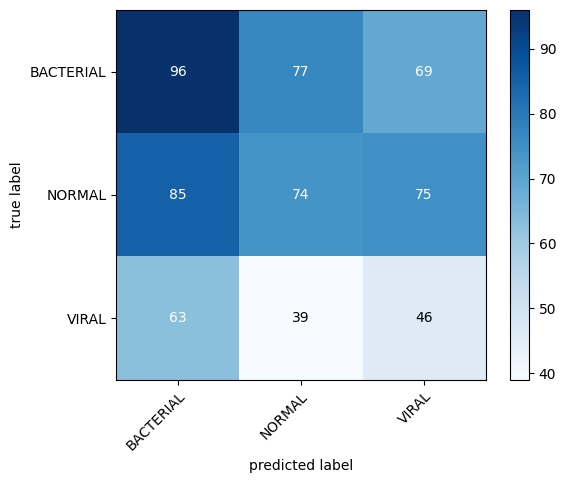

In [71]:
plot_confusion_matrix(cm,colorbar=True,class_names=class_names)

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 3s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 41ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 37ms/step


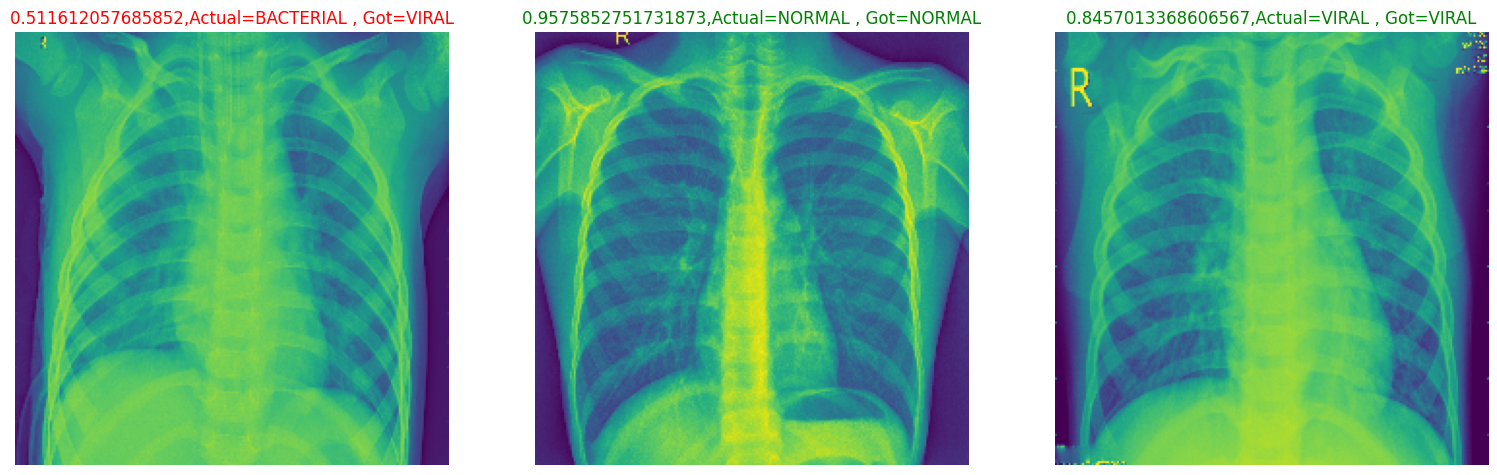

In [75]:
plt.figure(figsize=(19,10))
for i in range(3):
  class_name_1=random.choice(class_names)
  target_file="/content/chest_xray/chest_xray_ternary/test"
  target_image = random.sample(os.listdir(target_file +"/" + class_name_1),1)
  target_folder = target_file + "/" + class_name_1 + "/" + target_image[0]
  image = tf.io.read_file(target_folder)
  image = tf.io.decode_image(image)
  if image.shape[:-1] == 1:
    image = tf.image.grayscale_to_rgb(image)
  image = tf.image.resize(image,size=[224,224])
  pred_probs = model.predict(tf.expand_dims(image,axis=0))
  pred_class=class_names[int(tf.argmax(pred_probs,axis=1))]
  plt.subplot(1,3,i+1)
  plt.imshow(image/255)
  plt.title(pred_class)
  if pred_class == class_name_1:
    title_color="g"
  else:
    title_color="r"
  plt.title(f"{pred_probs.max()},Actual={class_name_1} , Got={pred_class}",c=title_color)
  plt.axis(False)

##Creating a new model model_2 whose architecture is same as the original model but what we do here is we add the model_2 with weight of our original model whos e weights are best that are saved using our callbacks

In [76]:
model_2 = model

In [77]:
model_2.summary()

Model: "functional_5"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                         ‚îÉ Output Shape                ‚îÉ         Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_layer_7 (InputLayer)           ‚îÇ (None, 224, 224, 3)         ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ sequential (Sequential)              ‚îÇ (None, None, None, 3)       ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ efficientnetb0 (Functional)          ‚îÇ (None, None, None, 1280)    ‚îÇ       4,049,571 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ global_average_pooling2d_4           ‚îÇ (None, 1280)                ‚îÇ               0 ‚îÇ
‚îÇ (GlobalAveragePooling2D)             ‚îÇ                             ‚îÇ                 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_4 (Dropout)                  ‚îÇ (None, 1280)                ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_4 (Dense)                      ‚îÇ (None, 3)                   ‚îÇ           3,843 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 5,847,566 (22.31 MB)

 Trainable params: 897,075 (3.42 MB)

 Non-trainable params: 3,156,339 (12.04 MB)

 Optimizer params: 1,794,152 (6.84 MB)

In [78]:
model.summary()

Model: "functional_5"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                         ‚îÉ Output Shape                ‚îÉ         Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_layer_7 (InputLayer)           ‚îÇ (None, 224, 224, 3)         ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ sequential (Sequential)              ‚îÇ (None, None, None, 3)       ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ efficientnetb0 (Functional)          ‚îÇ (None, None, None, 1280)    ‚îÇ       4,049,571 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ global_average_pooling2d_4           ‚îÇ (None, 1280)                ‚îÇ               0 ‚îÇ
‚îÇ (GlobalAveragePooling2D)             ‚îÇ                             ‚îÇ                 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_4 (Dropout)                  ‚îÇ (None, 1280)                ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_4 (Dense)                      ‚îÇ (None, 3)                   ‚îÇ           3,843 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 5,847,566 (22.31 MB)

 Trainable params: 897,075 (3.42 MB)

 Non-trainable params: 3,156,339 (12.04 MB)

 Optimizer params: 1,794,152 (6.84 MB)

In [79]:
model_2.load_weights("best_model.weights.h5")

In [80]:
y_pred_probs=model_2.predict(test_data,verbose=1)
y_pred_2=y_pred_probs.argmax(axis=1)
y_labels_2=[]
for images,labels in test_data.unbatch():
  y_labels_2.append(labels.numpy().argmax())
cm_2=confusion_matrix(y_labels_2,y_pred_2)

20/20 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 151ms/step


###The statistics of the best weighted model is slightly better than the original model . However the differnce is very minute.

(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

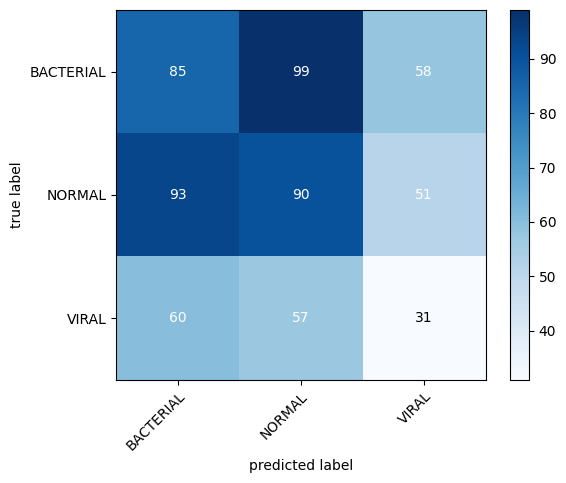

In [81]:
plot_confusion_matrix(cm_2,colorbar=True,class_names=class_names)

##Findings From this Notebook:
  -Our model is not the greatest or best might be because of the Imbalanced Datasets.
  -Transfer learning and Finetuning has increased the model efficiency to alot greater heigts.
##Steps that can be done to improve the model:
  -Use Balanced Datasets.
  -We can alter the learning rate to see the model improvements
  -We can FineTune more of our layer instead of only 10
  

In [ ]:
model_2.save("Model_2.h5")

In [100]:
tf.keras.models.save_model(model,"model.h5")

In [104]:
model.save_weights("weights.weights.h5")